# Restauração de Imagens - Mínimos Quadrados

## Bibliotecas utilizadas

In [36]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from math import sqrt
from scipy.signal import convolve2d
from skimage import color, data, measure, restoration
import matplotlib.pyplot as plt

## Funções

### Raíz Quadrada do Erro Médio (Root Mean Squared Error - RMSE)

In [37]:
def RMSE(image, corrupted_image):
  errors = []
  N = image.shape[0] * image.shape[1]
  sum = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      error = (int(image[i][j]) - int(corrupted_image[i][j]))**2
      sum += error
      errors.append(error)
  square_root = sqrt(sum)
  rmse = square_root/N
  return rmse

### getMotionDsf()

In [38]:
def getMotionDsf(shape, angle, dist):
  xCenter = (shape[0] - 1) / 2
  yCenter = (shape[1] - 1) / 2
  sinVal = np.sin(angle * np.pi / 180)
  cosVal = np.cos(angle * np.pi / 180)
  PSF = np.zeros(shape)
  for i in range(dist):
    xOffset = round(sinVal * i)
    yOffset = round(cosVal * i)
    PSF[int(xCenter - xOffset), int(yCenter + yOffset)] = 1
  return PSF / PSF.sum()

### makeBlurred()

In [39]:
def makeBlurred(image, PSF, eps):
  fftImg = np.fft.fft2(image)
  fftPSF = np.fft.fft2(PSF) + eps
  fftBlur = np.fft.ifft2(fftImg * fftPSF)
  fftBlur = np.abs(np.fft.fftshift(fftBlur))
  return fftBlur

### getPuv()

In [40]:
def getPuv(image):
  h, w = image.shape[:2]
  hPad, wPad = h - 3, w - 3
  pxy = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
  pxyPad = np.pad(pxy, ((hPad//2, hPad - hPad//2), (wPad//2, wPad - wPad//2)), mode='constant')
  fftPuv = np.fft.fft2(pxyPad)
  return fftPuv

### leaastSquareFilter()

In [41]:
def leastSquareFilter(image, PSF, eps, gamma=0.01):
  fftImg = np.fft.fft2(image)
  fftPSF = np.fft.fft2(PSF)
  conj = fftPSF.conj()
  fftPuv = getPuv(image)
  Huv = conj / (np.abs(fftPSF)**2 + gamma * (np.abs(fftPuv)**2))
  ifftImg = np.fft.ifft2(fftImg * Huv)
  ifftShift = np.abs(np.fft.fftshift(ifftImg))
  imgLSFilter = np.uint8(cv2.normalize(np.abs(ifftShift), None, 0, 255, cv2.NORM_MINMAX))
  return imgLSFilter

### RMSE_evaluation()

In [42]:
def RMSE_evaluation(original_image, restored_images):
  return [RMSE(original_image, restored_image) for restored_image in restored_images]

### resize_img()

In [43]:
def resize_img(img, scale):
  width = int(img.shape[1]*scale/100)
  height = int(img.shape[0]*scale/100)
  dim = (width, height)
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

### generate_interval()

In [62]:
def generate_interval(step, superior_limit, round_precision):
  gamma_values = []
  gamma = 0
  while (True):
    gamma += step
    gamma = round(gamma, round_precision)
    gamma_values.append(gamma)
    if (gamma == superior_limit): break
  return gamma_values

## Imagem orignal

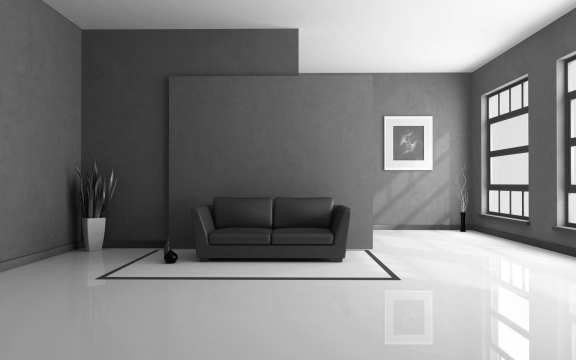

In [44]:
image = resize_img(cv2.imread('rosso', 0), 30)
cv2_imshow(image)

## Degradação da imagem

In [45]:
hImg, wImg = image.shape[:2]
PSF = getMotionDsf((hImg, wImg), 45, 100)

In [46]:
PSF = getMotionDsf((hImg, wImg), 45, 100)
imgBlurred = np.abs(makeBlurred(image, PSF, 1e-6))

scale = 0.01
noisy = imgBlurred.std() * np.random.normal(loc=0.0, scale=scale, size=imgBlurred.shape)
imgBlurNoisy = imgBlurred + noisy

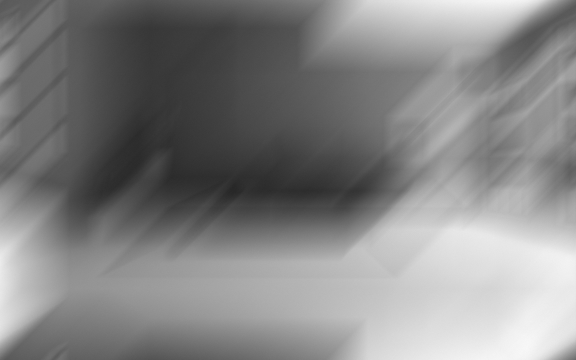

In [47]:
cv2_imshow(imgBlurNoisy)

Algo que foi observado desde a variação dos parâmetros para o filtro bilateral é que o borramento, quando em excesso, sobrepõe todas as demais características da imagem. Em outras palavras: uma vez que aumentamos o nível de borramento da imagem até o ponto em que sua qualidade fica prejudicada, a variação de outros parâmetros, mesmo do ruído, não consegue compensar a degradação gerada pelo borramento excessivo

Essa observação indica que a degradação realizada pelo borramento é uma espécie de parâmetro absoluto, independente de qualquer outro e não afetado pela variação deles. Desta forma, para qualquer outro parâmetro, existiria um valor máximo absoluto para o parâmetro **gamma**, que pode ser considerado o valor ótimo por suavizar a imagem sem comprometer a nitidez das bordas

Levando isso em conta, podemos aplicar a estratégia de, para um parâmetro qualquer e fixo da variância do ruído (parâmetro **eps**), variar os valores do gamma e usar a RMSE para estimar para qual valor a RMSE será minimizada

Uma vez encontrado o valor ótimo para o parâmetro **gamma**, podemos avaliar a hipótese da sua independência da variação de outros parâmtros, ao variar o valor de **eps** e observar se o valor de **gamma** para o qual a RMSE é minimizada contina o mesmo que para o primeiro parâmetro testado

#### Menor valor do gamma = 0.01; maior valor do gamma = 5
#### Primeiro valor constante de eps = 0.01

In [48]:
gamma_values = generate_interval(0.01, 5, 2)

In [49]:
print(gamma_values)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1

In [50]:
restored_images = [leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=gamma) for gamma in gamma_values]

In [51]:
results = [RMSE(image,restored_image) for restored_image in restored_images]

In [52]:
index = np.where(results == np.min(results))[0][0]
print('Menor RMSE',results[index])
print('Índice da menor RMSE', index)

Menor RMSE 0.030076537551364906
Índice da menor RMSE 0


O melhor valor para o parâmetro **gamma** obtido, de acordo com a aplicação da RMSE, foi de 0.01. A imagem abaixo mostra a imagem resultate da aplicação desse valor ao parâmetro

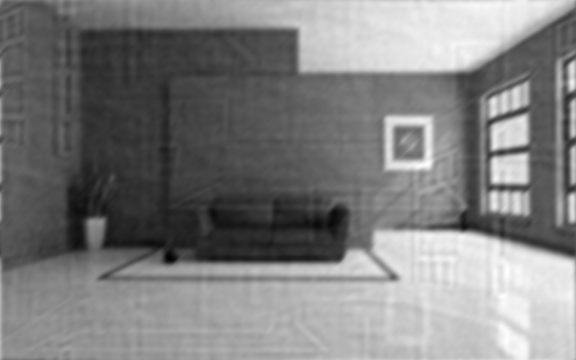

In [53]:
cv2_imshow(leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=0.01))

É interessante notar que o valor que minimizou a diferença entre a imagem restaurada e a original foi justamente o menor valor dentre todos os coeficientes *gamma* da lista de valores para o coeficinte. Analisando de uma forma superficial a lista dos coeficientes testados - que é mostrada abaixo - podemos ver que os valores parecem descrever um gráfico de uma reta com inclinação positiva, isso é, parece haver uma relação linear crescente entre os resultados da aplicação da RMSE e o coeficiente *gamma*. Os valores da RMSE parecem aumentar à medida em que os coeficientes aumentam, ou seja, quanto maior o coeficiente, mais distante parece ficar a imagem restaurada da imagem original

In [54]:
print(results)

[0.030076537551364906, 0.03231093699614743, 0.034026013366468676, 0.03545575526975899, 0.03660563614179061, 0.03767232273502133, 0.038651548755588315, 0.03954849125332526, 0.040361377692247, 0.040706247726352514, 0.041033051585845026, 0.041334290140632696, 0.04161597274134733, 0.041881847565027934, 0.04213333910544794, 0.04237292504866432, 0.0425974110287004, 0.042798130992418755, 0.042987313816257026, 0.04317333203294316, 0.043348554467320284, 0.04351708199625382, 0.04367788194431683, 0.04383352860558414, 0.043987062995278485, 0.044133652248795945, 0.044275739382516256, 0.04441425753043415, 0.04456157164123938, 0.044707870279498574, 0.04484167691934414, 0.04497434264279469, 0.04510359255661535, 0.045230416966428155, 0.045353518369698996, 0.04547299937160179, 0.0455894544365482, 0.045703609438646306, 0.04581333454617602, 0.04592275418401969, 0.046026754765666145, 0.04613046391089032, 0.04623135228929211, 0.04632965066890686, 0.04642558064015248, 0.04651966954115843, 0.04661153360394998

Ao plotar o *scatterplot* relacionando os coeficiente *gamma* com os resultados da RMSE, podemos vizualizar melhor o comportamento da função

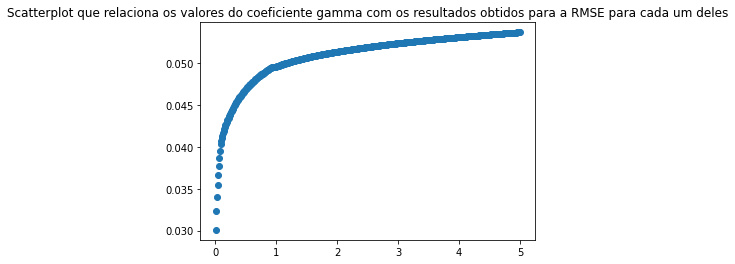

In [55]:
plt.scatter(gamma_values, results,);
plt.title('Scatterplot que relaciona os valores do coeficiente gamma com os resultados obtidos para a RMSE para cada um deles');

O gráfico, mostra, no entanto, que a relação entre essas duas variáveis não é linear, mas se assemelha mais a uma relação logarítima, com os valores da RMSE se estabilizando e tendendo a uma assíntota horizontal que tem valor aproximado de 0.055, à medida em que os valores dos coeficientes *gama* crescem

No que diz respeito a aumentar borramento da imagem esse de fato é o resultado esperado, considerando que uma vez que se atinge o valor ótimo para esse parâmetro, todos os outros valores farão com que a imagem restaurada se distancie da original

## Variação do *gamma* para valores menores

Esse raciocínio também se aplica a um limite inferior do intervalo de valores para no qual o valor ótimo do coeficiente pode ser encontrado: deve haver um valor mínimo para o intervalo de tal forma que, para os valores menores que ele, a imagem restaturada começa a se distanciar cada vez mais da imagem original

Considerando isso e também que o menor dos valores foi aquele considerado o melhor valor para o parâmetro dentre todos os testados, não podemos garantir que o valor encontrado é o melhor em um contexto mais amplo, porque ainda existem valores menores que são conveniente de serem testados

Podemos, então, analisar se para um intervalo com menores valores para **gamma** é possível encontrar um melhor resultado do que o que obtivemos

### Definição do limite inferior do intervalo

Sabemos que o limite superior para a análise com menores valores deve ser o 0.01, pois qualquer valor acima dele fará com que a imagem restaurada se distancie cada vez mais da imagem original

Testamos incialmente o valor 0.0001

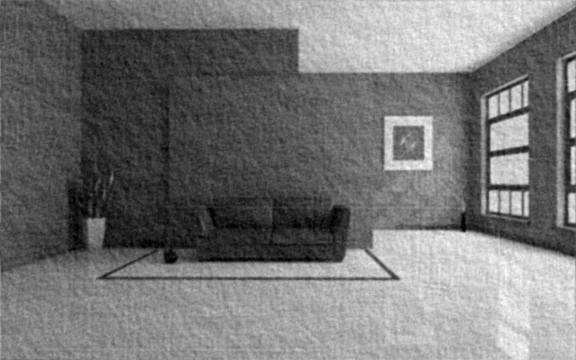

In [71]:
test_00001 = leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=0.0001)
cv2_imshow(test_00001)

In [72]:
RMSE_evaluation(image,[test_00001])

[0.04413262623981405]

Considerando que o resultado para o coeficiente 0.0001 foi de fato menor que o para 0.01, ele se trata de um intervalo inferior conveiente



Consideraremos, portanto, um intervalo com valores discretos cujo limite inferior será 0.001 e superior de 0.01, com saltos de 0.001

In [74]:
gamma_values_least = generate_interval(0.0001, 0.01, 4)

In [75]:
print(gamma_values_least)

[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.002, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003, 0.0031, 0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004, 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047, 0.0048, 0.0049, 0.005, 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056, 0.0057, 0.0058, 0.0059, 0.006, 0.0061, 0.0062, 0.0063, 0.0064, 0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007, 0.0071, 0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008, 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088, 0.0089, 0.009, 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.0096, 0.0097, 0.0098, 0.0099, 0.01]


In [76]:
restored_images_least = [leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=gamma) for gamma in gamma_values_least]

In [77]:
results_least = [RMSE(image,restored_image) for restored_image in restored_images_least]

In [78]:
index = np.where(results_least == np.min(results_least))[0][0]
print('Menor RMSE',results_least[index])
print('Índice da menor RMSE', index)

Menor RMSE 0.02968393028215317
Índice da menor RMSE 73


De fato, consegimos um melhor resultado do que que ateriormente por meio da análise de um intervalo com menores valores

O melhor valor encontrado para o coficiente *gamma* dentre os testados foi **0.074**

In [82]:
gamma_values_least[index]

0.0074

A imagem mostrada abaixo corresponde à aplicação do filtro de Mínimos Quadrados na imagem degrada para o valor **0.0074**, que, dentre os testados, foi o que apresentou o melhor resultado

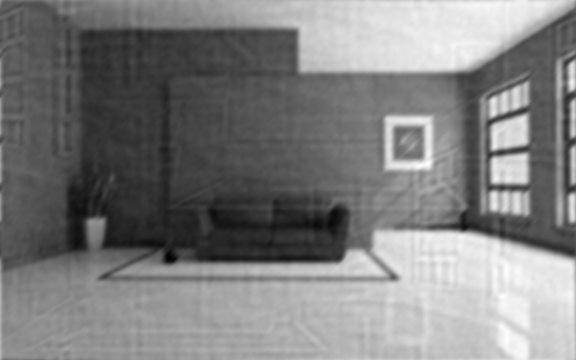

In [80]:
cv2_imshow(restored_images_least[index])

O gráfico da relação entre as variáveis também apresenta um aspecto logarítmico e em certos pontos os resultados da RMSE oscilam entre valores mais altos e mais baixos

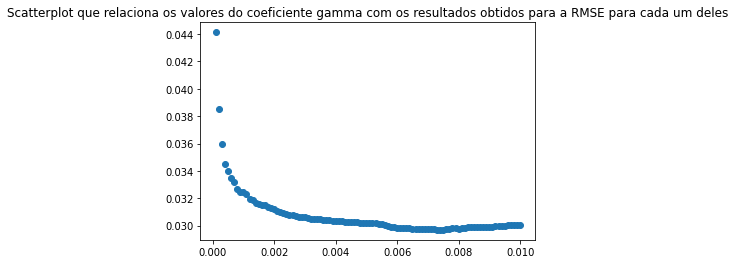

In [83]:
plt.scatter(gamma_values, results,);
plt.title('Scatterplot que relaciona os valores do coeficiente gamma com os resultados obtidos para a RMSE para cada um deles');

### Conclusão

In [ ]:
gamma_values_all = gamma_values_least + gamma_values

In [ ]:
results_all = results_least + results

In [ ]:
plt.scatter(gamma_values_all, results_all);
plt.title('Scatterplot que relaciona os valores do coeficiente gamma com os resultados obtidos para a RMSE para cada um deles');

Considerando a independência do parâmtro **gamma** dos demais e também que para os valores menores que o limite infeior que definimos agora os resultados da RMSE tendem apenas a aumentar (mostrando que para eles a imagem restaurada fica cada vez mais distante da original) e da mesma forma para os valores acima do limite superior que definimos na análise anterior, podemos conluir que encontramos o valor ótimo para o coeficiente *gamma* com quatro casas decimais de precisão